In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from functools import partial
from sklearn.decomposition import PCA


In [2]:
# Change matplotlib backend to one that you like
# ipympl works well interactively in VSCode
# qt otherwise
%matplotlib ipympl

In [3]:
path = pd.read_csv('path.csv')
tracker = pd.read_csv('tracker.csv')

## First Overview

In [4]:
# Quick overviews
print(f"path info:")
path.info()
print(f"tracker info:")
tracker.info()
print(f"path first entries:", f"{path.iloc[:10]}", sep='\n')
print(f"tracker first entries:", f"{tracker.iloc[:10]}", sep='\n')
print(f"path last entries:", f"{path.iloc[-10:]}", sep='\n')
print(f"tracker last entries:", f"{tracker.iloc[-10:]}", sep='\n')
# index==3180 first entry in index column that's the same for both path and tracker datasets 
t_diff_same_index = (path.loc[path['index'] == 3180]['t_pth'].values[0] - tracker.loc[tracker['index'] == 3180]['t_trk'].values[0])*1e-9
print(f"Diff for same index: {t_diff_same_index} sec")
# Not sure what the 'index' column is for...
print(f"Num entries in tracker is {len(tracker)/len(path)} times larger than path")

path info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145841 entries, 0 to 145840
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  145841 non-null  int64  
 1   index       145841 non-null  int64  
 2   x_pth       145841 non-null  float64
 3   y_pth       145841 non-null  float64
 4   z_pth       145841 non-null  float64
 5   t_pth       145841 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 6.7 MB
tracker info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546943 entries, 0 to 546942
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  546943 non-null  int64  
 1   index       546943 non-null  int64  
 2   x_trk       546943 non-null  float64
 3   y_trk       546943 non-null  float64
 4   z_trk       546943 non-null  float64
 5   t_trk       546943 non-null  int64  
dtypes: float64(3), int64(3)
memo

In [5]:
# Unifiy colum names
column_names = ['unnamed', 'index', 'x', 'y', 'z', 't']
path.columns = column_names
tracker.columns = column_names

In [6]:
# Global values for slicing
START = 0
END = 100
SKIP = 50
TAILLENGTH = 400

#### Some helper functions

In [7]:

def df_mean_of_diffs(df, column, scale=1):
    tdata = df[[column]]
    diff = tdata.diff()
    return diff.mean().values[0]*scale

def df_var_of_diffs(df, column, scale=1):
    tdata = df[[column]]
    diff = tdata.diff()
    return diff.var().values[0]*scale

def df_start(df, column, scale=1):
    return df[[column]].iloc[0].values[0]*scale

def df_end(df, column, scale=1):
    return df[[column]].iloc[-1].values[0]*scale
    
def df_min(df, column, scale=1):
    return df[[column]].min().values[0]*scale

def df_max(df, column, scale=1):
    return df[[column]].max().values[0]*scale

### Investigating time

In [8]:

# Looks like nano sec resolution (1e-9) with unix epoch 1/1/1970
print(f'time step path: {df_mean_of_diffs(path, "t", 1e-9 )} sec, var: {df_var_of_diffs(path, "t", 1e-9)}')
print(f'time step tracker: {df_mean_of_diffs(tracker, "t", 1e-9 )} sec, var: {df_var_of_diffs(tracker, "t", 1e-9)}')

# Variance of tracker timestamps is not null, so investigate further

start_time_path = df_start(path, "t", 1e-9)
end_time_path = df_end(path, "t", 1e-9)
print(f'start time path: {start_time_path} sec, end: {end_time_path} sec')
print(f'start time tracker based on path: {df_start(tracker, "t", 1e-9)-start_time_path} sec, end: {df_end(tracker, "t", 1e-9)-end_time_path} sec')

# Something weird is going on with the timestamp of the tracker data
# Let's keep digging
print(f'min of tracker timestamp diff: {tracker[["t"]].diff().min().values[0]*1e-9} sec, max: {tracker[["t"]].diff().max().values[0]*1e-9} sec')

# tracker time steps are between 0.0036 sec and 0.072 sec
# path time steps are constant   0.05 sec
# Both datasets start at roughly the same time (+0.28 sec) and end roughly at the same time (+1.38 sec)


time step path: 0.05 sec, var: 0.0
time step tracker: 0.0133343082447499 sec, var: 1565.1635220479013
start time path: 1633969004.3500001 sec, end: 1633976296.3500001 sec
start time tracker based on path: 0.2838711738586426 sec, end: 1.3770909309387207 sec
min of tracker timestamp diff: 0.0036330000000000004 sec, max: 0.07236300000000001 sec


### Helper functions for 3D plots


In [9]:
# TODO add type hints for all functions

def get_data_slices(df, start, end, skip):
    """ Slices pandas dataframe
    :param df: pandas dataframe
    :param start: index
    :param end: index
    :param skip: samples to skip
    :return: tuple of sliced data from x, y, z, t column
    """
    if start <= 0:
        start = 0
    xdata = df[['x']].iloc[start:end:skip]
    ydata = df[['y']].iloc[start:end:skip]
    zdata = df[['z']].iloc[start:end:skip]
    tdata = df[['t']].iloc[start:end:skip]
    return xdata, ydata, zdata, tdata

# computationally intense...
# Either cache some timestamps, or since timestamps are already sorted
# memorize them, so we can use them in future calls as 'quick' known
# entry points / hints. 
#@cache available in >= 3.9
# !!! cache only works with the same df for now...
# Now deprecated, because data was filtered by timestamps
def find_closest_timestamp(df, timestamp, _cache = {}):
    if timestamp in _cache:
        id = _cache[timestamp]
    else:
        id = df[['t']].sub(timestamp).abs().idxmin().values[0]
        _cache[timestamp] = id

    return id

def update_plot(slider, ax3d, fig, time_step, path, tracker, val):
    """ Callback function for interactive 3d plot
    :param slider: matplotlib slider object (bound)
    :param time_step: time resolution to convert returned slider number to index (bound)
    :param path: data of path (bound)
    :param tracker: data of tracker (bound)
    :val: required by matplotlib, currently not used
    """
    path_index = int(slider.val / time_step)
    path_start = int(path_index - TAILLENGTH/time_step)
    slice_path = get_data_slices(path, path_start, path_index, SKIP)
    # because t_steps are different, we have to look for the
    # correct index corresponding to path ind's
    #tracker_index = find_closest_timestamp(tracker, path[['t']].iloc[path_index].values[0])
    tracker_index = path_index
    tracker_start = path_start
    slice_tracker = get_data_slices(tracker, tracker_start, tracker_index, SKIP)
    ax3d.clear()
    #ax3d.scatter3D(slice_path[0], slice_path[1], slice_path[2], c='blue', cmap='hsv')
    #ax3d.scatter3D(slice_tracker[0], slice_tracker[1], slice_tracker[2], c='red', cmap='hsv')
    ax3d.scatter3D(slice_path[0], slice_path[1], slice_path[2], c=slice_path[3], cmap='Blues')
    ax3d.scatter3D(slice_tracker[0], slice_tracker[1], slice_tracker[2], c=slice_tracker[3], cmap='Reds')
    fig.canvas.draw()
    fig.canvas.draw()


## Filter tracking samples

In [10]:
print(f"path time stamps are ordered: {path['t'].is_monotonic_increasing}")
print(f"tracker tiem stamps are ordered: {tracker['t'].is_monotonic_increasing}")
print()

# Merge tracker data with path data -> for each path timestamp find closest tracker timestamp and merge those two rows
# Gets rid of unnecessary samples in tracker
# Choose only columns related to tracker samples and rename the columns
tracker_filtered = pd.merge_asof(path.iloc[6:], tracker, "t", suffixes=('_path', '_tracker'))
tracker_filtered = tracker_filtered[['unnamed_tracker', 'index_tracker',  'x_tracker', 'y_tracker', 'z_tracker', 't']]
tracker_filtered.columns = column_names

# Can't find closest time stamp for first 6 samples
# TODO causes SettingWithCopyWarning later on in sub_mean()...
path_filtered = path.iloc[6:,:]

print(len(path_filtered))
print(len(tracker_filtered))

path time stamps are ordered: True
tracker tiem stamps are ordered: True

145835
145835


## First interactive 3D plot of raw (not yet transformed) data
#### Move slider...

0

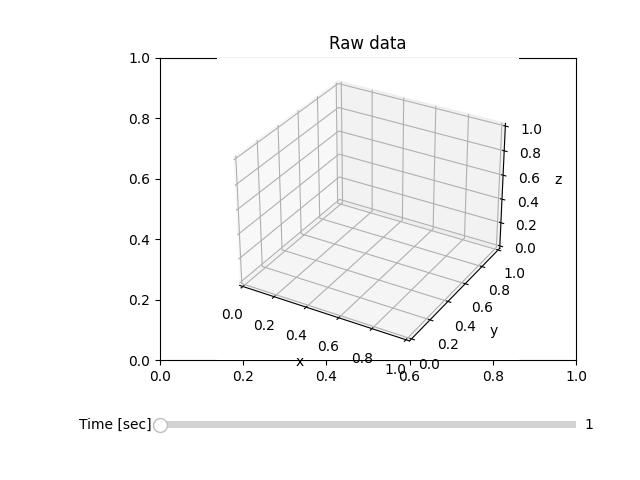

In [11]:
# Can't move this block into a function because then data
# in plot isn't updated anymore... 
fig = plt.figure()
ax = plt.subplot(111, label='a')
fig.subplots_adjust(left=0.25, bottom=0.25)
ax3d = plt.axes(projection='3d', label='b')
ax3d.set_xlabel('x')
ax3d.set_ylabel('y')
ax3d.set_zlabel('z')

plt.title('Raw data')

t_bias = df_start(path, "t", 1e-9)
t_end = (df_end(path, "t", 1e-9) - t_bias)
t_step = df_mean_of_diffs(path, "t", 1e-9 )

ax_time = plt.axes([0.25, 0.1, 0.65, 0.03])
slider = Slider(ax_time, 'Time [sec]', 1., t_end, valinit=0, valstep=10)

slider.on_changed(partial(update_plot, slider, ax3d, fig, t_step, path_filtered, tracker_filtered))



### Observations:
- tracker has more time steps than path
    - Could get rid of some rows in tracker to avoid costly call to `find_closest_timestamp` and only keep the rows with timestamps closest to the timestamps of path (see filtered dataframes above)
- values in 'index' columns increas with each entry
- Recording of ~ 2hrs
- Tracker circles look smooshed
- Affine transformation 'fixes' our smooshed tracker path, but it also scales and shears it

### How to find offset in timestamps of both datasets relative to each other

In order to find deviations of the timestamps (i.e. tracker and path clocks are different), we can use `find_coord_trans()` and and error metric for minimization. We'd need to iterate over different slices of the tracker and path data ([START:END]) and find the two slices with the smallest error.

I won't be able to try this because time is running out. It's computationally expensive, so it's best to constrict the slices (e.g. keep a constant slice of the path data and only change the slice of the tracker data within a well-defined region). Also check if the error gets smaller or larger. Only keep going if error gets smaller.

In [12]:
# Based on https://github.com/nghiaho12/rigid_transform_3D
# Finds euclidean 3d translation vectors + rotation matrices (no scaling etc.)
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

R, t = rigid_transform_3D(tracker_filtered[['x', 'y', 'z']].to_numpy().T,
                    path_filtered[['x', 'y', 'z']].to_numpy().T) 
print(R)
print(t)

[[-0.39134868  0.29979517 -0.87003969]
 [-0.90350332  0.05433399  0.42512301]
 [ 0.17472255  0.95245508  0.2496024 ]]
[[-2088.98490866]
 [ 1908.57798296]
 [  772.71271809]]


## Find affine coordinate transformation matrix

In [13]:
def pad(data):
    """ Adds padding of '1s' as column vector to right side of
        data
        :param data: nxm data to be padded
        :return: returns nx(m+1) padded data
    """
    return np.hstack([data, np.ones((data.shape[0], 1))])

def unpad(data):
    """ Removes right most column (can be padding)
    :param data: nxm data to be padded
    :return: nx(m-1) data
    """
    return data[:,:-1]

def transform(data, A):
    """ Applies affine transformation on data with A
    :param data: nxm data to be transformed
    :param A: Affine (m+1)x(m+1) transformation matrix
    :return: transformed data
    """
    return unpad(np.dot(pad(data), A))

def compute_max_err(data1, data2):
    """ Computes max norm error of two datasets
    """
    return np.abs(data1 - transform(data2, A)).max()

# Affine transformation (also does scaling, shearing, etc.)
def find_coord_trans(data1, data2):
    """ Computes approximate affine transformation matrix A
    :param data1: first dataset
    :param data2: second dataset
    :return: Matrix A for which data1 @ A = data2
    """
    Y = pad(data1)
    X = pad(data2)
    A, res, rank, s = np.linalg.lstsq(X, Y, rcond=None)
    A[np.abs(A) < 1e-10] = 0
    return A

A = find_coord_trans(path_filtered[['x', 'y', 'z']].to_numpy(),
                    tracker_filtered[['x', 'y', 'z']].to_numpy()) 
print(A)

[[ 6.98389191e-01 -1.03778777e+00  0.00000000e+00  0.00000000e+00]
 [ 6.21503371e+00 -6.95162220e-01  0.00000000e+00  0.00000000e+00]
 [ 6.89135637e-01  2.28459286e-01  0.00000000e+00  0.00000000e+00]
 [ 2.73641611e+03  1.29991395e+03  0.00000000e+00  1.00000000e+00]]


## Transform tracker data with euclidean transformation

In [14]:
# Alternatively, transform with affine matrix from find_coord_trans()
transformed_tracker = R @ (tracker_filtered[['x', 'y', 'z']].to_numpy().T) + t
tracker_transformed = tracker_filtered.copy()
tracker_transformed[['x', 'y', 'z']] = transformed_tracker.T
slider.on_changed(partial(update_plot, slider, t_step, path_filtered, tracker_transformed))


1

In [15]:
transformed_tracker = transform(tracker_filtered[['x', 'y', 'z']].to_numpy(), A)
tracker_affine = tracker_filtered.copy()
tracker_affine[['x', 'y', 'z']] = transformed_tracker

## Another interactive 3D plot
### This time with the transformed tracker data

0

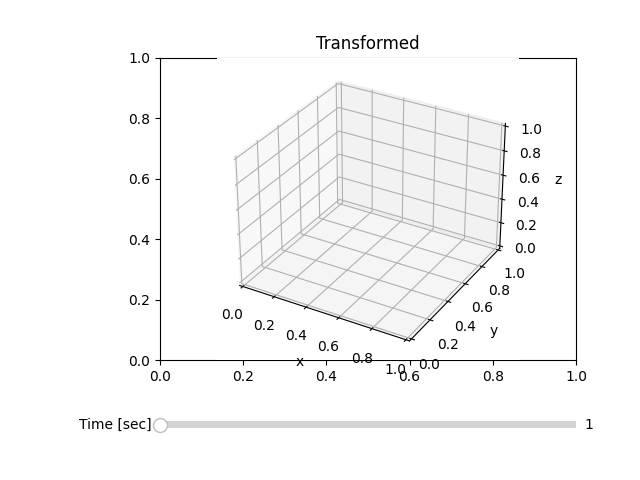

In [16]:
fig_ = plt.figure()
ax_ = plt.subplot(111, label='a')
fig_.subplots_adjust(left=0.25, bottom=0.25)
ax3d_ = plt.axes(projection='3d', label='b')
ax3d_.set_xlabel('x')
ax3d_.set_ylabel('y')
ax3d_.set_zlabel('z')

plt.title('Transformed')

ax_time_ = plt.axes([0.25, 0.1, 0.65, 0.03])
slider_ = Slider(ax_time_, 'Time [sec]', 1., t_end, valinit=0, valstep=10)

slider_.on_changed(partial(update_plot, slider_, ax3d_, fig_, t_step, path_filtered, tracker_transformed))


## Plotting some error graphs

Text(0.5, 1.0, 'Absolute error for each dimension\n (on transformed tracker data)')

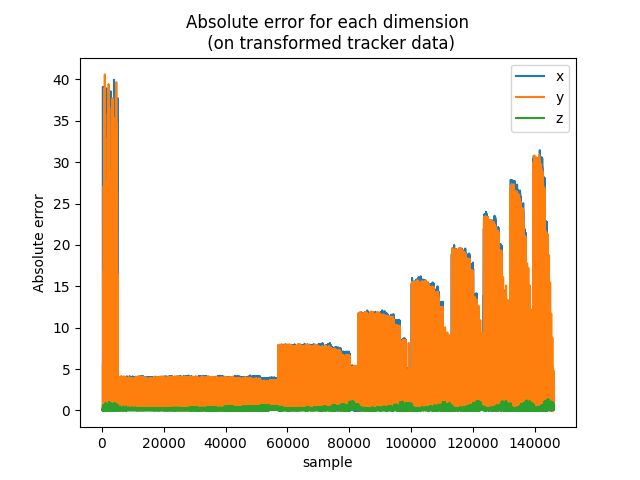

In [17]:
# TODO create subplots for each dimension, so that data doesn't overlap

# plot error of transformed data (euclidean)
fig = plt.figure()
plt.plot(path_filtered['index'].values, np.abs((tracker_transformed['x'].values-path_filtered['x'].values)))
plt.plot(path_filtered['index'].values, np.abs((tracker_transformed['y'].values-path_filtered['y'].values)))
plt.plot(path_filtered['index'].values, np.abs((tracker_transformed['z'].values-path_filtered['z'].values)))
plt.xlabel('sample')
plt.ylabel('Absolute error')
plt.legend(('x', 'y', 'z'))
plt.title("Absolute error for each dimension\n (on transformed tracker data)")

#### Please zoom in the data!

Text(0.5, 1.0, 'Absolute error for each dimension\n (on AFFINE transformed tracker data)')

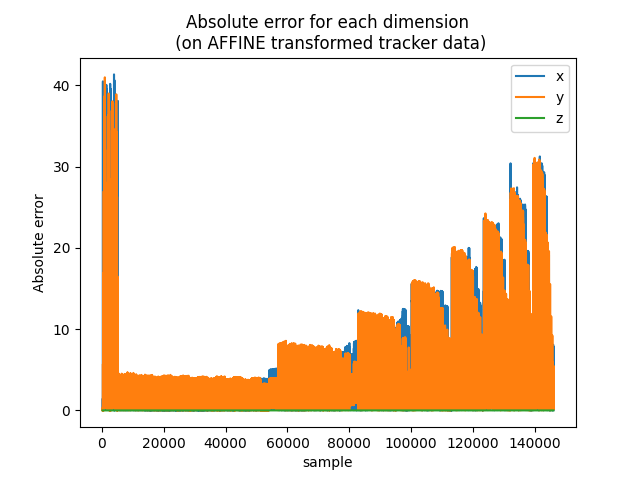

In [18]:
# Sorry for copy & pasting the code. Moving it to a function didn't work as expected with matplotlib...

# plot error of transformed data (affine)
fig = plt.figure()
plt.plot(path_filtered['index'].values, np.abs((tracker_affine['x'].values-path_filtered['x'].values)))
plt.plot(path_filtered['index'].values, np.abs((tracker_affine['y'].values-path_filtered['y'].values)))
plt.plot(path_filtered['index'].values, np.abs((tracker_affine['z'].values-path_filtered['z'].values)))
plt.xlabel('sample')
plt.ylabel('Absolute error')
plt.legend(('x', 'y', 'z'))
plt.title("Absolute error for each dimension\n (on AFFINE transformed tracker data)")

Text(0.5, 1.0, 'Normalized absolute error for each dimension\n (on transformed tracker data)')

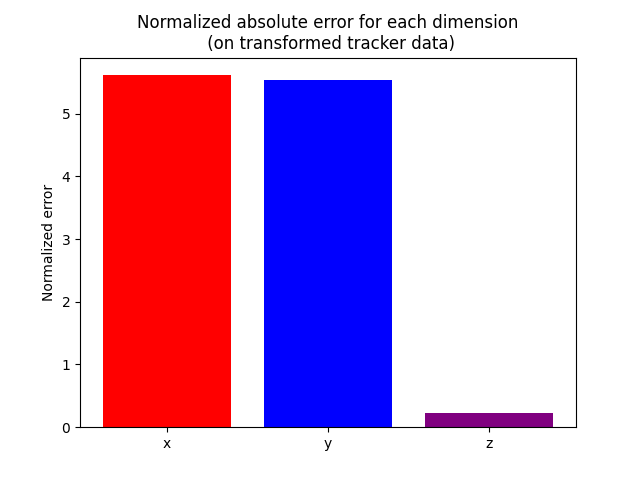

In [19]:
# plot error of normalized total for each dimension

fig = plt.figure()
plt.bar(np.arange(3), np.array([np.sum(np.abs((tracker_transformed['x'].values-path_filtered['x'].values))),
                        np.sum(np.abs((tracker_transformed['y'].values-path_filtered['y'].values))),
                        np.sum(np.abs((tracker_transformed['z'].values-path_filtered['z'].values)))])/len(path_filtered),
        color=['red', 'blue', 'purple'],
        tick_label=['x', 'y', 'z'])

plt.ylabel('Normalized error')
plt.title("Normalized absolute error for each dimension\n (on transformed tracker data)")

## PCA analysis
Less than 0.1% difference in singular values between the tracker and path datasets... Seems like they are the same base on PCA?!

But nice to see that explained variance and singular values stayed the same after the euclidean transformation.

In [20]:
def get_pca_info(data):
    pca = PCA(n_components=3)
    pca.fit(data)
    print("components ", pca.components_)
    print("variance ", pca.explained_variance_)
    print("variance ratio ", pca.explained_variance_ratio_)
    print("singular values ", pca.singular_values_)
    print()

for df in [path_filtered, tracker_filtered, tracker_transformed]:
    get_pca_info(df[['x', 'y', 'z']])





components  [[-8.00154053e-06 -1.00000000e+00 -0.00000000e+00]
 [-1.00000000e+00  8.00154053e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
variance  [7772.00513939 2590.47161907    0.        ]
variance ratio  [0.75001424 0.24998576 0.        ]
singular values  [33666.34220549 19436.53359256     0.        ]

components  [[ 0.90377898 -0.05455428 -0.42450841]
 [ 0.39074316 -0.29956655  0.87039052]
 [ 0.17465204  0.95251442  0.24942524]]
variance  [7.75843591e+03 2.58506538e+03 8.20964049e-02]
variance ratio  [7.50072351e-01 2.49919712e-01 7.93694040e-06]
singular values  [33636.94015674 19416.24125833   109.41867805]

components  [[-7.08653870e-04 -9.99999749e-01 -8.24081980e-06]
 [-9.99999729e-01  7.08652211e-04  1.99520007e-04]
 [ 1.99514117e-04 -8.38220819e-06  9.99999980e-01]]
variance  [7.75843591e+03 2.58506538e+03 8.20964049e-02]
variance ratio  [7.50072351e-01 2.49919712e-01 7.93694040e-06]
singular values  [33636.94015674 19416.24125833   109.41867805]

## Conclusion

Based on the error plot it seems that there are large deviations in x and y direction. Less in z direction. 

In the non-transformed 3D plot the tracked data looks smooshed, however PCA only showed tiny differences in variance and singular values. Are they the same after all??? Probably not, if the robot arm didn't move correctly. So when it moved, it moved more or less correctly (including the measurement error introduced by the tracking hardware), but sometimes it didn't move correctly at all.

The error plots are quite interesting. It seems that there are distinct jumps at certain time stamps (e.g. 56K, 82K, 100K) where the error increases significantly for each sample. After each increase the error per sample never quite reaches the pre-jump values, thus the error increases over time. Something over time must be shifting e.g. maybe the robot arm or tracking system aren't mounted correctly.

I couldn't find the 'registration' points, so the coordination transformation was quite tricky to do. 

Sadly, I'm running out of time and have to stop here. With more time I'd investigate and look at the data in 3D whenever there is a jump in the error value to see what happens then.